In [1]:
!pip3 install torch torchvision torchaudio --quiet
!pip install gpytorch --quiet
!pip install mne --quiet
!pip install pandas --quiet
!pip install pywavelets --quiet
!pip install edfio --quiet
!pip install tqdm --quiet
!pip install lifelines --quiet
!pip install POT --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autovizwidget 0.21.0 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.2.2 which is incompatible.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.2 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.2 which is incompatible.


In [2]:
import os
import tqdm
import ot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from itertools import product
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import seaborn as sns
from lifelines import CoxPHFitter

import mne
from mne.stats.parametric import _parametric_ci
from mne import create_info
from mne.io import RawArray

from KC_algorithm.model import score_KCs
from KC_algorithm.utils import EpochData
from KC_algorithm.plotting import KC_from_probas, plot_all_Kcs

from utils.plots import plot_Kcs_in_single_chart, plot_Kcs_in_single_chart_epoch_data, plot_kcs_per_minute_and_sleep_stages, KC_from_probas_epoch_data
from utils.io import import_event_and_stages_SHHS, get_total_recording_time, store_kcs_data, load_kcs_edf_files, load_invalid_kc_metadata, load_valid_kc_metadata
from utils.preprocessing import remove_steady_epochs, remove_standard_deviation_outliers
from utils.postprocessing import calculate_kcs_per_minute, filter_kcs_by_sleep_stages

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

Updated sk-learn import path


In [3]:
DATASET_DIR = "/home/ec2-user/SageMaker/datasets/nsrr/shhs/"

datasets_dir = os.path.join(DATASET_DIR, 'datasets')

# Individual datasets with population & events data
population_dataset_enriched = os.path.join(datasets_dir, 'shhs1-dataset-0.20.0.csv')
events_dataset = os.path.join(datasets_dir, 'shhs-cvd-summary-dataset-0.20.0.csv')
variables_dataset = os.path.join(datasets_dir, 'shhs-data-dictionary-0.20.0-variables.csv')
kox_model_refinement_dir = os.path.join(DATASET_DIR, "kox-model-refinement")

density_dataset = os.path.join(datasets_dir, 'enriched-avg-kc-density-backup.csv')
features_dataset = os.path.join(datasets_dir, 'enriched-kc_features-backup.csv')

# Load the datasets to make them globally available
variables_df = pd.read_csv(variables_dataset)
events_df = pd.read_csv(events_dataset)
density_df = pd.read_csv(density_dataset)
features_df = pd.read_csv(features_dataset)


# Gender and age category labels
GENDER_LABELS = {1: 'Male', 2: 'Female'}
AGE_LABELS = {
    5: '35-44 years', 6: '45-54 years', 7: '55-64 years',
    8: '65-74 years', 9: '75-84 years', 10: '85 years or older'
}

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
print("Features df has: ", len(features_df["nsrrid"].unique()))
print("Density df has: ", len(density_df["nsrrid"].unique()))

# Check if they have the same unique nsrrid values
features_ids = set(features_df["nsrrid"].unique())
density_ids = set(density_df["nsrrid"].unique())

print("Do they have the same ids? ", features_ids == density_ids)

Features df has:  5793
Density df has:  5793
Do they have the same ids?  True


In [6]:
# Drop 'Unnamed: 0' and 'index' columns if they exist
features_df = features_df.drop(columns=['Unnamed: 0', 'index'], errors='ignore')
density_df = density_df.drop(columns=['Unnamed: 0', 'index'], errors='ignore')
# Find overlapping columns (excluding 'nsrrid')
overlapping_columns = set(features_df.columns).intersection(set(density_df.columns)) - {'nsrrid'}
print("Overlapping columns:", overlapping_columns)
# Remove overlapping columns from one of the DataFrames (here we choose density_df)
density_df = density_df.drop(columns=overlapping_columns, errors='ignore')
# Merge the DataFrames on 'nsrrid'
population_df = pd.merge(features_df, density_df, on='nsrrid', how='inner')

Overlapping columns: {'bmi_s1', 'waist', 'height', 'minsat', 'gender', 'avgsat', 'ethnicity', 'age_category_s1', 'weight'}


In [7]:
population_df.shape

(5793, 934)

In [8]:
population_df.head()

,nsrrid,bmi_s1,gender,height,weight,waist,age_category_s1,avgsat,minsat,ethnicity,avg_std_kc-thr_0.5-sleepstages_2-smoothing_5,global_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_index-thr_0.5-sleepstages_2-smoothing_5,global_min_std-thr_0.5-sleepstages_2-smoothing_5,global_min_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_max_value-thr_0.5-sleepstages_2-smoothing_5,min_max_duration-thr_0.5-sleepstages_2-smoothing_5,max_max_duration-thr_0.5-sleepstages_2-smoothing_5,variance_duration-thr_0.5-sleepstages_2-smoothing_5,right_peak_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_index-thr_0.5-sleepstages_2-smoothing_5,right_peak_std-thr_0.5-sleepstages_2-smoothing_5,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_index-thr_0.5-sleepstages_2-smoothing_5,left_peak_std-thr_0.5-sleepstages_2-smoothing_5,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_5,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_5,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_5,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_5,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_5,avg_std_kc-thr_0.5-sleepstages_2-smoothing_10,global_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_index-thr_0.5-sleepstages_2-smoothing_10,global_min_std-thr_0.5-sleepstages_2-smoothing_10,global_min_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_max_value-thr_0.5-sleepstages_2-smoothing_10,min_max_duration-thr_0.5-sleepstages_2-smoothing_10,max_max_duration-thr_0.5-sleepstages_2-smoothing_10,variance_duration-thr_0.5-sleepstages_2-smoothing_10,right_peak_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_index-thr_0.5-sleepstages_2-smoothing_10,right_peak_std-thr_0.5-sleepstages_2-smoothing_10,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_index-thr_0.5-sleepstages_2-smoothing_10,left_peak_std-thr_0.5-sleepstages_2-smoothing_10,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_10,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_10,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_10,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_10,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_10,avg_std_kc-thr_0.5-sleepstages_2-smoothing_20,global_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_index-thr_0.5-sleepstages_2-smoothing_20,global_min_std-thr_0.5-sleepstages_2-smoothing_20,global_min_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_max_value-thr_0.5-sleepstages_2-smoothing_20,min_max_duration-thr_0.5-sleepstages_2-smoothing_20,max_max_duration-thr_0.5-sleepstages_2-smoothing_20,variance_duration-thr_0.5-sleepstages_2-smoothing_20,right_peak_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_index-thr_0.5-sleepstages_2-smoothing_20,right_peak_std-thr_0.5-sleepstages_2-smoothing_20,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_index-thr_0.5-sleepstages_2-smoothing_20,left_peak_std-thr_0.5-sleepstages_2-smoothing_20,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_20,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_20,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_20,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_20,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_20,avg_std_kc-thr_0.5-sleepstages_3-smoothing_5,global_min_value-thr_0.5-sleepstages_3-smoothing_5,global_min_index-thr_0.5-sleepstages_3-smoothing_5,global_min_std-thr_0.5-slee

### Explore Events
- The following is partially copied from the official [SHHS Dataset Description](https://www.sleepdata.org/datasets/shhs/pages/04-dataset-introduction.md)
- shhs-cvd (CVD Outcomes): tracking of adjudicated heart health outcomes (e.g. stroke, heart attack) between baseline and 2008-2011 (varies by parent cohort)(5,802 rows, outcomes data were not provided on all subjects)
- shhs-cvd-events (CVD Outcome Events): event-level details for the tracking of heart health outcomes 4,839 rows, representing individual events

Key outcomes for SHHS include the following incident or recurrent CVD events or diagnoses occurring subsequent to the first SHHS PSG:

- Hospitalized acute MI (HAMI)
- Coronary surgical intervention -- percutaneous transcutaneous angioplasty (PTCA), coronary stent placement, coronary artery bypass grafting (CABG)
- Congestive Heart Failure (CHF)
- Coronary heart disease death
- Any coronary heart disease (CHD) -- summary variable which includes 1, 2, and 4 above.
- Any cardiovascular disease (CVD) -- summary variable which includes 1 to 4 above.
- Angina pectoris (AP) -- at CHS and FHS only

#### What we want to track
Anything related to mortality, stroke, etc. This results in the following "labels":

- vital: Vital status at last contact
- prev_mi: Number of myocardial infarctions (MIs) *Prior* to Baseline (=Heart Attack -> Heart)
- prev_mip: Number of Procedures Related to Heart Attack *Prior* to Baseline
- prev_stk: Number of Strokes *Prior* to Baseline (Stroke -> Brain)
- mi_fatal: Fatal Heart Attack Since Baseline [True/False]
- stk_fatal: Fatal Stroke Since Baseline [True/False]
- chd_death: Fatal Coronary Heart Disease (CHD) Since Baseline [True/False]
- cvd_death: Fatal Cardiovascular Disease (CVD) Since Baseline [True/False]
- any_chd: Any Coronary Heart Disease (CHD) Since Baseline [True/False]
- any_cvd: Any Cardiovascular Disease (CVD) Since Baseline [True/False]
variables_df

### Understand behaviour of prev_* vs. normal
- Check global correlations
- Check correlations by Gender/Age combination

In [9]:
prev_selected_columns = ["nsrrid", "prev_mi", "prev_mip", "prev_stk", "prev_chf", "prev_revpro", "prev_ang"]

In [10]:
events_df_prev_illnes = events_df[prev_selected_columns]
events_df_prev_illnes.describe()

,nsrrid,prev_mi,prev_mip,prev_stk,prev_chf,prev_revpro,prev_ang
count,5802.000000,5042.000000,5042.000000,5042.000000,5042.000000,3144.000000,2216.000000
mean,202901.860565,0.147759,0.174336,0.051765,0.038278,0.048664,0.137184
std,1675.549290,0.935631,0.982868,0.500246,0.280848,0.236338,0.517982
min,200001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201451.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,202901.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,204351.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,205804.000000,22.000000,22.000000,18.000000,7.000000,4.000000,8.000000


In [11]:
# Map events_df_prev_illnes with population_df on nsrrid column
population_events_df = pd.merge(population_df, events_df_prev_illnes, on='nsrrid', how='left')
population_events_df.shape

(5793, 940)

In [12]:
# Drop rows where we don't have labels
rows_with_prev_stk = population_events_df.dropna(subset=['prev_stk'])
rows_with_prev_stk.shape

(5037, 940)

In [13]:
rows_with_prev_stk.head()

,nsrrid,bmi_s1,gender,height,weight,waist,age_category_s1,avgsat,minsat,ethnicity,avg_std_kc-thr_0.5-sleepstages_2-smoothing_5,global_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_index-thr_0.5-sleepstages_2-smoothing_5,global_min_std-thr_0.5-sleepstages_2-smoothing_5,global_min_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_max_value-thr_0.5-sleepstages_2-smoothing_5,min_max_duration-thr_0.5-sleepstages_2-smoothing_5,max_max_duration-thr_0.5-sleepstages_2-smoothing_5,variance_duration-thr_0.5-sleepstages_2-smoothing_5,right_peak_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_index-thr_0.5-sleepstages_2-smoothing_5,right_peak_std-thr_0.5-sleepstages_2-smoothing_5,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_index-thr_0.5-sleepstages_2-smoothing_5,left_peak_std-thr_0.5-sleepstages_2-smoothing_5,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_5,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_5,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_5,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_5,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_5,avg_std_kc-thr_0.5-sleepstages_2-smoothing_10,global_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_index-thr_0.5-sleepstages_2-smoothing_10,global_min_std-thr_0.5-sleepstages_2-smoothing_10,global_min_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_max_value-thr_0.5-sleepstages_2-smoothing_10,min_max_duration-thr_0.5-sleepstages_2-smoothing_10,max_max_duration-thr_0.5-sleepstages_2-smoothing_10,variance_duration-thr_0.5-sleepstages_2-smoothing_10,right_peak_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_index-thr_0.5-sleepstages_2-smoothing_10,right_peak_std-thr_0.5-sleepstages_2-smoothing_10,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_index-thr_0.5-sleepstages_2-smoothing_10,left_peak_std-thr_0.5-sleepstages_2-smoothing_10,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_10,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_10,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_10,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_10,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_10,avg_std_kc-thr_0.5-sleepstages_2-smoothing_20,global_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_index-thr_0.5-sleepstages_2-smoothing_20,global_min_std-thr_0.5-sleepstages_2-smoothing_20,global_min_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_max_value-thr_0.5-sleepstages_2-smoothing_20,min_max_duration-thr_0.5-sleepstages_2-smoothing_20,max_max_duration-thr_0.5-sleepstages_2-smoothing_20,variance_duration-thr_0.5-sleepstages_2-smoothing_20,right_peak_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_index-thr_0.5-sleepstages_2-smoothing_20,right_peak_std-thr_0.5-sleepstages_2-smoothing_20,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_index-thr_0.5-sleepstages_2-smoothing_20,left_peak_std-thr_0.5-sleepstages_2-smoothing_20,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_20,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_20,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_20,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_20,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_20,avg_std_kc-thr_0.5-sleepstages_3-smoothing_5,global_min_value-thr_0.5-sleepstages_3-smoothing_5,global_min_index-thr_0.5-sleepstages_3-smoothing_5,global_min_std-thr_0.5-slee

#### Check Correlation

In [14]:
# List of columns of interest
columns_of_interest = ['prev_mi', 'prev_mip', 'prev_stk', 'prev_chf', 'prev_revpro', 'prev_ang']

# Calculate the correlation matrix
correlation_matrix = rows_with_prev_stk.corr()

# Extract correlations for the columns of interest
correlations = correlation_matrix[columns_of_interest]

# Sort the correlations for each column of interest
sorted_correlations = correlations.abs().sort_values(by=columns_of_interest, ascending=False)

In [15]:
sorted_correlations.head(30)

,prev_mi,prev_mip,prev_stk,prev_chf,prev_revpro,prev_ang
prev_mi,1.000000,0.968592,0.067135,0.200404,0.124622,0.288406
prev_mip,0.968592,1.000000,0.063528,0.205768,0.285534,0.375260
prev_ang,0.288406,0.375260,0.074209,0.297274,0.556830,1.000000
prev_chf,0.200404,0.205768,0.285223,1.000000,0.095866,0.297274
age_category_s1,0.143403,0.155835,0.088269,0.142846,0.056524,0.179317
prev_revpro,0.124622,0.285534,0.003078,0.095866,1.000000,0.556830
nsrrid,0.081143,0.085205,0.044077,0.060626,0.022900,0.165508
left_peak_max_value-thr_0.5-sleepstages_3-smoothing_5,0.075953,0.076991,0.037054,0.059220,0.033058,0.076913
left_peak_max_value-thr_0.5-sleepstages_3-smoothing_10,0.075953,0.076991,0.037054,0.059220,0.033058,0.076913
left_peak_max_value-thr_0.5-sleepstages_3-smoothing_20,0.075953,0.076991,0.037054,0.059220,0.033058,0.076913


#### Create Box Plots by Gender/Age

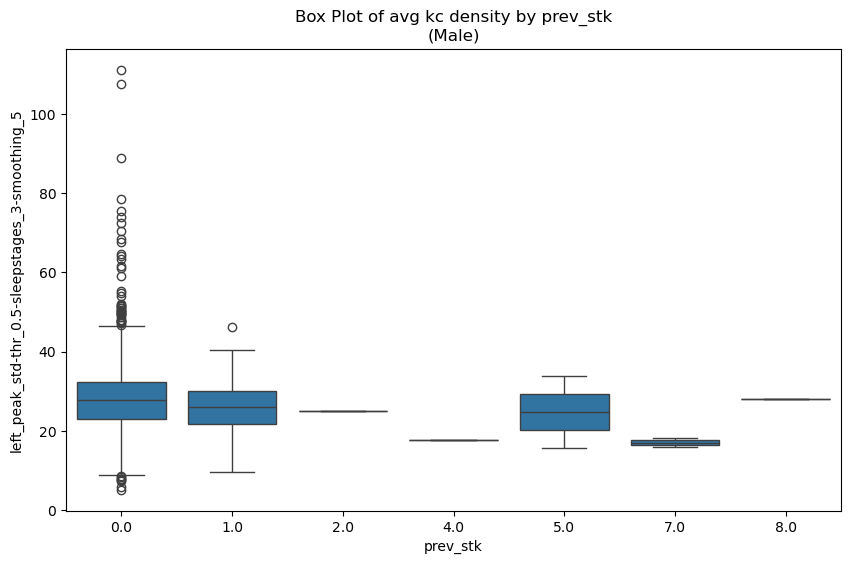

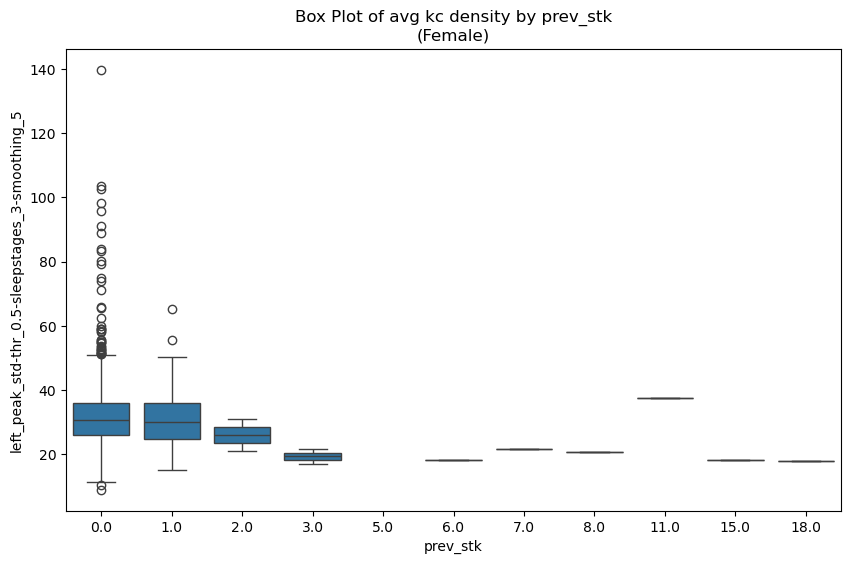

In [16]:
def create_box_plots_by_group(data, x_feature, y_feature, group_by_features):
    unique_groups = data[group_by_features].drop_duplicates()
    
    for _, group in unique_groups.iterrows():
        group_data = data
        title_parts = []
        for feature in group_by_features:
            group_data = group_data[group_data[feature] == group[feature]]
            if feature == 'gender':
                title_parts.append(f"{GENDER_LABELS[group[feature]]}")
            elif feature == 'age_category_s1':
                title_parts.append(f"{AGE_LABELS[group[feature]]}")
            else:
                title_parts.append(f"{feature}={group[feature]}")
        
        title = ", ".join(title_parts)
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=x_feature, y=y_feature, data=group_data)
        plt.title(f'Box Plot of avg kc density by {x_feature}\n({title})')
        plt.xlabel(x_feature)
        plt.ylabel(y_feature)
        plt.show()

# Example usage:
# Create box plots of avg_kc_density by number of previous strokes, grouped by gender and age category
create_box_plots_by_group(
    data=rows_with_prev_stk,
    x_feature='prev_stk',
    y_feature='left_peak_std-thr_0.5-sleepstages_3-smoothing_5',
    group_by_features=['gender'] #age_category_s1, gender
)

# y_feature='max_kc_density-thr_0.5-sleepstages_2_3',
# y_feature='left_peak_max_value-thr_0.5-sleepstages_3-smoothing_5',
# y_feature='left_peak_std-thr_0.5-sleepstages_3-smoothing_5',

### Cox Regression

#### SHHS1 (Baseline and First Follow-up Visits):

- Data Collection Period: Between November 1, 1995, and January 31, 1998.
- Participants: 6441 individuals.
- Purpose: Establish baseline measurements for sleep-disordered breathing and associated cardiovascular and other health outcomes.
- Inclusion Criteria: Age 40 years or older, no history of treatment for sleep apnea, no tracheostomy, no current home oxygen therapy.
- Data Collected: Initial polysomnogram (PSG), various cardiovascular risk factors, and other health data.


#### Events Data:

- Baseline: The initial PSG and associated health data collected during SHHS1 (1995-1998).
- Follow-up: Subsequent health events recorded after SHHS1, including cardiovascular events, revascularization procedures, heart attacks, strokes, and mortality. The follow-up events data extends from the baseline period to the time of the last contact or death.


In [108]:
# List of columns to exclude
id_columns = ['nsrrid']
one_hot_columns = ['gender', 'ethnicity', 'age_category_s1']
numeric_columns = population_df.columns.difference(one_hot_columns + id_columns)

# Events columns
event_prev_events_columns = ['prev_mi', 'prev_mip', 'prev_stk', 'prev_chf', 'prev_revpro', 'prev_ang']
event_numeric_columns = ["age_s1"]
event_additional_columns = ["censdate"]
event_id_columns = ["nsrrid"]

# Values to use for the features df
events_features_df = events_df[event_id_columns + event_numeric_columns + event_additional_columns + event_prev_events_columns]

time_event_dict = {
    'mi_date': 'mi',  # Days to First myocardial infarction (MI) Since Baseline
    'mip_date': 'mip',  # Days to First myocardial infarction (MI) Procedure Since Baseline
    'stk_date': 'stroke',  # Days to First Stroke Since Baseline
    'chd_dthdt': 'chd_death',  # Days to Fatal Coronary Heart Disease (CHD) Since Baseline
    'cvd_dthdt': 'cvd_death',  # Days to Fatal Cardiovascular Disease (CVD) Since Baseline
    'ang_date': 'angina',  # Days to First Angina Episodes Since Baseline
    'revpro_date': 'revasc_proc',  # Days to First Revascularization Procedure Since Baseline
    'ptca_date': 'ptca',  # Days to First Percutaneous transluminal coronary angioplasty (PTCA) Since Baseline
    'cabg_date': 'cabg',  # Days to First coronary artery bypass graft surgery (CABG) Since Baseline
    'chf_date': 'chf',  # Days to First Congestive Heart Failure (CHF) Since Baseline
    'censdate': 'vital'  # Days to Most Recent Contact or Death Since Baseline
}

# Seperate the different columns columns
feature_id_columns = ['nsrrid']
feature_one_hot_columns = ['gender', 'ethnicity', 'age_category_s1']
feature_numeric_columns = list(population_df.columns.difference(one_hot_columns + id_columns))


# Merge the final dataset
events_df_population = pd.merge(population_df, events_features_df, on='nsrrid', how='left')

# Columns names by preprocessing type
final_id_columns = feature_id_columns
final_one_hot_columns = feature_one_hot_columns
final_numeric_columns = feature_numeric_columns + event_numeric_columns + event_prev_events_columns

### Preprocess

In [109]:
# Preprocess the data
# One-hot encode categorical columns
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

# Process each one-hot column
one_hot_encoded_frames = []
for column in feature_one_hot_columns:
    encoded = one_hot_encoder.fit_transform(events_df_population[[column]])
    encoded_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out([column]))
    one_hot_encoded_frames.append(encoded_df)

# Drop the original categorical columns and concatenate the one-hot encoded columns
events_df_population = events_df_population.drop(columns=feature_one_hot_columns)
events_df_population = pd.concat([events_df_population] + one_hot_encoded_frames, axis=1)

# Standardize numerical columns
events_df_population[final_numeric_columns] = (events_df_population[final_numeric_columns] - events_df_population[final_numeric_columns].mean()) / events_df_population[final_numeric_columns].std()

In [110]:
events_df_population.head()

,nsrrid,bmi_s1,height,weight,waist,avgsat,minsat,avg_std_kc-thr_0.5-sleepstages_2-smoothing_5,global_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_index-thr_0.5-sleepstages_2-smoothing_5,global_min_std-thr_0.5-sleepstages_2-smoothing_5,global_min_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_max_value-thr_0.5-sleepstages_2-smoothing_5,min_max_duration-thr_0.5-sleepstages_2-smoothing_5,max_max_duration-thr_0.5-sleepstages_2-smoothing_5,variance_duration-thr_0.5-sleepstages_2-smoothing_5,right_peak_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_index-thr_0.5-sleepstages_2-smoothing_5,right_peak_std-thr_0.5-sleepstages_2-smoothing_5,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_index-thr_0.5-sleepstages_2-smoothing_5,left_peak_std-thr_0.5-sleepstages_2-smoothing_5,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_5,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_5,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_5,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_5,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_5,avg_std_kc-thr_0.5-sleepstages_2-smoothing_10,global_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_index-thr_0.5-sleepstages_2-smoothing_10,global_min_std-thr_0.5-sleepstages_2-smoothing_10,global_min_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_max_value-thr_0.5-sleepstages_2-smoothing_10,min_max_duration-thr_0.5-sleepstages_2-smoothing_10,max_max_duration-thr_0.5-sleepstages_2-smoothing_10,variance_duration-thr_0.5-sleepstages_2-smoothing_10,right_peak_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_index-thr_0.5-sleepstages_2-smoothing_10,right_peak_std-thr_0.5-sleepstages_2-smoothing_10,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_index-thr_0.5-sleepstages_2-smoothing_10,left_peak_std-thr_0.5-sleepstages_2-smoothing_10,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_10,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_10,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_10,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_10,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_10,avg_std_kc-thr_0.5-sleepstages_2-smoothing_20,global_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_index-thr_0.5-sleepstages_2-smoothing_20,global_min_std-thr_0.5-sleepstages_2-smoothing_20,global_min_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_max_value-thr_0.5-sleepstages_2-smoothing_20,min_max_duration-thr_0.5-sleepstages_2-smoothing_20,max_max_duration-thr_0.5-sleepstages_2-smoothing_20,variance_duration-thr_0.5-sleepstages_2-smoothing_20,right_peak_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_index-thr_0.5-sleepstages_2-smoothing_20,right_peak_std-thr_0.5-sleepstages_2-smoothing_20,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_index-thr_0.5-sleepstages_2-smoothing_20,left_peak_std-thr_0.5-sleepstages_2-smoothing_20,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_20,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_20,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_20,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_20,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_20,avg_std_kc-thr_0.5-sleepstages_3-smoothing_5,global_min_value-thr_0.5-sleepstages_3-smoothing_5,global_min_index-thr_0.5-sleepstages_3-smoothing_5,global_min_std-thr_0.5-sleepstages_3-smoothing_5,global_min_

### Select target values for Cox

In [111]:
# Select target values for Cox regression
event_duration_col = "stk_date"
event_event_col = time_event_dict[event_duration_col]

event_data = events_df[["nsrrid", event_duration_col, event_event_col]]

In [112]:
# Merge the datasets
final_df = pd.merge(events_df_population, event_data, on='nsrrid')
final_df = final_df.drop(["nsrrid"], axis=1)

In [113]:
print("Final dataframe has shape: ", final_df.shape)

Final dataframe has shape:  (5791, 947)


### Prepare for Cox

- Drop collinear data
- Drop NaN

In [114]:
# Prepare data for Cox Proportional Hazards Model
cox_features = final_df.columns.difference([event_duration_col, event_event_col])
cox_data = final_df[cox_features.tolist() + [event_duration_col, event_event_col]]

In [115]:
collinear_cols = ["age_category_s1_10", "age_category_s1_6", "age_category_s1_7", "age_category_s1_8", "age_category_s1_9", "min_kc_density-thr_0.5-sleepstages_3", "min_kc_density-thr_0.7-sleepstages_3", "min_kc_density-thr_0.8-sleepstages_3", "min_kc_density-thr_0.9-sleepstages_3", "prev_mip"]
#collinear_cols += ['censdate']
collinear_cols += ['ethnicity_2']
columns_to_keep = list(cox_data.columns.difference(collinear_cols))
columns_to_keep = [col for col in columns_to_keep if "smoothing_10" not in col and "smoothing_20" not in col]
columns_to_keep = [col for col in columns_to_keep if ("sleepstages_" in col and "sleepstages_2_3" in col and "thr_0.9" in col) or "sleepstages_" not in col]

In [116]:
cox_data = cox_data[columns_to_keep]

In [117]:
cox_data.head()

,age_s1,avg_kc_density-thr_0.9-sleepstages_2_3,avg_std_kc-thr_0.9-sleepstages_2_3-smoothing_5,avgsat,bmi_s1,censdate,fft_feature_05_2-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_0_35-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_1_45-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_2_55-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_3_65-thr_0.9-sleepstages_2_3-smoothing_5,gender_2,global_min_index-thr_0.9-sleepstages_2_3-smoothing_5,global_min_max_value-thr_0.9-sleepstages_2_3-smoothing_5,global_min_min_value-thr_0.9-sleepstages_2_3-smoothing_5,global_min_std-thr_0.9-sleepstages_2_3-smoothing_5,global_min_value-thr_0.9-sleepstages_2_3-smoothing_5,height,left_peak_index-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_max_value-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_min_value-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_std-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_value-thr_0.9-sleepstages_2_3-smoothing_5,max_kc_density-thr_0.9-sleepstages_2_3,max_max_duration-thr_0.9-sleepstages_2_3-smoothing_5,median_kc_density-thr_0.9-sleepstages_2_3,min_kc_density-thr_0.9-sleepstages_2_3,min_max_duration-thr_0.9-sleepstages_2_3-smoothing_5,minsat,prev_ang,prev_chf,prev_mi,prev_revpro,prev_stk,right_peak_index-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_max_value-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_min_value-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_std-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_value-thr_0.9-sleepstages_2_3-smoothing_5,std_kc_density-thr_0.9-sleepstages_2_3,stk_date,stroke,variance_duration-thr_0.9-sleepstages_2_3-smoothing_5,waist,weight
0,-0.724572,-0.317194,0.545833,-0.827401,-1.254315,5440.0,-0.154233,0.527754,-0.376884,-0.100736,-0.101184,0.0,NaN,0.823936,-0.131928,0.116584,-0.511742,1.096706,-1.648422,-0.235459,0.360176,-0.423346,-0.915164,-0.343859,0.415390,-0.128131,NaN,-0.403667,-0.092500,NaN,NaN,NaN,NaN,NaN,1.098765,-0.045747,-1.354343,0.070069,-0.792261,-0.351631,NaN,NaN,-0.798221,-0.806161,-0.818812
1,1.323472,0.234429,-0.380395,-0.104833,0.939953,4672.0,-0.757228,-0.379158,-0.090439,0.803268,-0.032146,0.0,NaN,-0.169544,0.104994,-0.099250,0.295704,0.053017,-0.116230,-0.234136,0.449385,-0.364584,-0.009695,1.335717,-1.900635,-0.128131,NaN,-1.358550,-0.569473,NaN,NaN,NaN,NaN,NaN,-1.276588,-0.097462,-0.062594,-0.074588,-0.093058,0.463711,NaN,NaN,-0.348301,0.727179,0.915671
2,1.234427,-0.433345,-0.241855,0.428129,-0.795436,4635.0,-0.007480,-0.078986,-0.569604,-0.152523,-0.050459,1.0,NaN,0.666105,0.041394,-0.038445,0.098872,-2.347467,-0.086187,-0.479476,0.674902,-0.371807,-0.098749,0.495929,0.369070,-0.128131,NaN,1.592905,-0.569473,NaN,NaN,NaN,NaN,NaN,1.037858,-0.039224,0.589151,-0.013705,-0.034478,-0.322981,NaN,NaN,1.404835,-1.098225,-1.686054
3,-1.347890,0.163708,0.066346,0.695716,-1.567037,5142.0,0.763739,0.252547,1.522033,-0.127417,-0.041958,0.0,NaN,0.253079,0.027856,0.005331,-0.143859,1.305444,0.544716,0.322483,0.538517,0.406108,2.133833,-0.343859,0.044826,-0.128131,NaN,0.290793,1.020437,NaN,NaN,NaN,NaN,NaN,-0.667523,0.027165,-0.381733,-0.021655,-0.085828,0.092585,NaN,NaN,0.846314,-0.879177,-0.880758
4,0.254927,-0.611431,-0.623671,0.031192,-0.953547,4121.0,-0.682374,-0.456837,-0.570059,0.076711,0.004819,1.0,NaN,0.550188,0.106945,-0.062078,0.530962,-1.303778,-0.657004,-0.407593,0.372719,-0.480136,-0.738138,0.495929,-0.279418,-0.128131,NaN,-1.445357,-0.410482,NaN,NaN,NaN,NaN,NaN,-1.337494,-0.071696,0.507260,-0.056614,-0.070356,-0.517714,NaN,NaN,-1.046453,-1.536322,-1.376325


In [118]:
cox_data.shape

(5791, 45)

In [119]:
# Drop columns where all data is NaN
print("Before dropping all NaN columns: ", cox_data.shape)
cox_data = cox_data.dropna(axis=1, how='all')
print("After dropping all NaN columns: ", cox_data.shape)

Before dropping all NaN columns:  (5791, 45)
After dropping all NaN columns:  (5791, 43)


In [120]:
# Drop rows where event_event_col is NaN
print("Before dropping rows where event_event_col NaN: ", cox_data.shape)
cox_data = cox_data.dropna(subset=[event_event_col])
print("After dropping rows where event_event_col NaN: ", cox_data.shape)

Before dropping rows where event_event_col NaN:  (5791, 43)
After dropping rows where event_event_col NaN:  (5037, 43)


In [121]:
# Censor data where event_duration_col is NaN
cox_data[event_event_col] = cox_data.apply(
    lambda row: 0 if pd.isna(row[event_duration_col]) else row[event_event_col], axis=1)

# Impute missing event_duration_col with most recent contact time or a specified value
# For this example, we'll use the 'censdate' if available, otherwise drop those rows
if 'censdate' in cox_data.columns:
    print("Censdate found")
    cox_data[event_duration_col] = cox_data.apply(
        lambda row: row['censdate'] if pd.isna(row[event_duration_col]) else row[event_duration_col], axis=1)
else:
    # Drop rows where event_duration_col is NaN if 'censdate' is not available
    cox_data = cox_data.dropna(subset=[event_duration_col])

Censdate found


In [122]:
# Drop Censdate
cox_data_copy = cox_data.drop(["censdate"], axis=1)

In [123]:
# Drop all other NaN
print("Before dropping all other NaN: ", cox_data_copy.shape)
cox_data_copy = cox_data_copy.dropna()
print("After dropping all other NaN: ", cox_data_copy.shape)

Before dropping all other NaN:  (5037, 42)
After dropping all other NaN:  (1157, 42)


In [105]:
cox_data_copy.head()

,age_s1,avg_kc_density-thr_0.9-sleepstages_2_3,avg_std_kc-thr_0.9-sleepstages_2_3-smoothing_5,avgsat,bmi_s1,fft_feature_05_2-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_0_35-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_1_45-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_2_55-thr_0.9-sleepstages_2_3-smoothing_5,fft_feature_3_65-thr_0.9-sleepstages_2_3-smoothing_5,gender_2,global_min_max_value-thr_0.9-sleepstages_2_3-smoothing_5,global_min_min_value-thr_0.9-sleepstages_2_3-smoothing_5,global_min_std-thr_0.9-sleepstages_2_3-smoothing_5,global_min_value-thr_0.9-sleepstages_2_3-smoothing_5,height,left_peak_index-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_max_value-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_min_value-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_std-thr_0.9-sleepstages_2_3-smoothing_5,left_peak_value-thr_0.9-sleepstages_2_3-smoothing_5,max_kc_density-thr_0.9-sleepstages_2_3,max_max_duration-thr_0.9-sleepstages_2_3-smoothing_5,median_kc_density-thr_0.9-sleepstages_2_3,min_max_duration-thr_0.9-sleepstages_2_3-smoothing_5,minsat,prev_ang,prev_chf,prev_mi,prev_revpro,prev_stk,right_peak_index-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_max_value-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_min_value-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_std-thr_0.9-sleepstages_2_3-smoothing_5,right_peak_value-thr_0.9-sleepstages_2_3-smoothing_5,std_kc_density-thr_0.9-sleepstages_2_3,stk_date,stroke,variance_duration-thr_0.9-sleepstages_2_3-smoothing_5,waist,weight
1185,1.056336,-0.648125,-0.928467,-0.694184,1.364472,0.068282,0.001427,-0.462309,-0.121218,-0.023365,0.0,-0.665439,0.065673,-0.046263,0.027298,1.075832,-1.347992,-0.729116,1.112232,-0.818103,-1.054596,-0.343859,1.202839,-0.128131,2.808209,-1.364428,1.664788,-0.136365,6.251677,4.023961,-0.103531,1.525110,-0.111608,1.017262,-0.129892,-0.074791,-0.722153,1553.0,1.0,-0.534475,1.895438,2.185561
1186,1.412517,-0.311282,-0.608866,0.061263,-0.770421,-0.023516,-0.023743,-0.201112,-0.240115,-0.093419,0.0,0.255137,0.007459,-0.021112,0.259648,-0.364459,0.424544,-0.225002,0.979169,-0.496030,-0.370262,-0.343859,0.785954,-0.128131,1.679712,0.384473,3.594546,-0.136365,-0.158005,4.023961,-0.103531,0.794232,0.026121,1.043465,-0.102583,0.064628,-0.137625,162.0,0.0,0.194706,-0.879177,-0.905536
1187,0.967290,0.863459,-0.467880,0.719336,0.222406,-0.229618,-0.220269,-0.239130,0.039949,-0.001682,1.0,1.138738,0.059292,-0.046106,0.135745,-1.721254,0.064028,-0.229589,-0.134470,-0.333787,-0.807924,0.495929,-0.742623,-0.128131,0.551215,0.066491,-0.264971,-0.136365,-0.158005,-0.205977,-0.103531,0.185168,-0.050126,0.571766,-0.095458,-0.038359,1.219936,4388.0,0.0,-0.286243,0.216066,-0.670142
1188,1.145381,2.431830,-0.027658,1.353640,-1.593451,0.107961,-0.009086,-0.164156,-0.027729,-0.079389,1.0,1.299014,-0.071932,0.023693,-0.037860,-0.416643,-0.807219,0.965598,-0.821673,-0.308398,-1.050115,2.175505,-0.047815,-0.128131,0.377600,-0.092500,-0.264971,-0.136365,-0.158005,-0.205977,-0.103531,-0.180271,0.176034,-0.435216,-0.055183,-0.084218,2.214115,3242.0,0.0,-0.798221,-1.536322,-1.401103
1189,0.967290,0.192198,-0.306616,-1.914313,-1.015013,-0.225563,-0.223754,0.041948,0.022086,-0.042467,1.0,-1.173640,0.010808,-0.066682,-0.033683,-0.552323,0.995361,-0.302001,-0.444063,-0.160146,-0.739374,-0.343859,-0.557341,-0.128131,0.638022,-0.569473,-0.264971,-0.136365,-0.158005,-0.205977,-0.103531,0.246074,-0.033218,0.118262,-0.052935,0.016427,0.134807,3021.0,0.0,-0.953366,-0.587112,-0.843590


In [124]:
cox_data_gender_female = cox_data_copy[cox_data_copy["gender_2"] == 1]
cox_data_gender_female = cox_data_gender_female.drop(["gender_2"], axis=1)
cox_data_gender_female.shape

(682, 42)

In [129]:
cox_data_gender_male = cox_data_copy[cox_data_copy["gender_2"] == 0]
cox_data_gender_male = cox_data_gender_male.drop(["gender_2"], axis=1)
cox_data_gender_male.shape

(475, 41)

In [131]:
# Fit Cox Proportional Hazards Model
cph = CoxPHFitter(penalizer = 0.1) #penalizer=0.5
cph.fit(cox_data_gender_male, duration_col=event_duration_col, event_col=event_event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 475 total observations, 420 right-censored observations>
             duration col = 'stk_date'
                event col = 'stroke'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 475
number of events observed = 55
   partial log-likelihood = -310.33
         time fit was run = 2024-07-24 12:13:22 UTC

---
                                                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                 
age_s1                                                    0.22      1.25      0.27           -0.30            0.75                0.74                2.11
avg_kc_density-thr_0.9-sleepstages_2_3                   -0.04      0.96      0.11           -0.24            0.17                0.78                1.18
avg_std_kc-thr_0.9-sleepstages_2_3-smoothing_5            0.07      1.07      0.12           -0.17            0.31                0.84                1.37
avgsat                                                   -0.08      0.92      0.10           -0.28            0.12                0.75                1.13
bmi_s1                                                   -0.02      0.98      0.16           -0.33            0.28                0.72                1.33
fft_feature_05_2-thr_0.9-sleepstages_2_3-smoothing_5     -0.02      0.98      0.18           -0.37            0.32                0.69                1.38
fft_feature_0_35-thr_0.9-sleepstages_2_3-smoothing_5      0.03      1.03      0.20           -0.36            0.42                0.70                1.52
fft_feature_1_45-thr_0.9-sleepstages_2_3-smoothing_5      0.12      1.12      0.20           -0.27            0.50                0.76                1.65
fft_feature_2_55-thr_0.9-sleepstages_2_3-smoothing_5      0.07      1.07      0.48           -0.88            1.02                0.42                2.76
fft_feature_3_65-thr_0.9-sleepstages_2_3-smoothing_5      0.46      1.58      1.03           -1.56            2.47                0.21               11.84
global_min_max_value-thr_0.9-sleepstages_2_3-smoothing_5 -0.03      0.97      0.11           -0.25            0.19                0.78                1.21
global_min_min_value-thr_0.9-sleepstages_2_3-smoothing_5 -0.11      0.90      1.10           -2.26            2.04                0.10                7.67
global_min_std-thr_0.9-sleepstages_2_3-smoothing_5        0.30      1.35      1.16           -1.97            2.57                0.14               13.00
global_min_value-thr_0.9-sleepstages_2_3-smoothing_5     -0.06      0.94      0.24           -0.53            0.40                0.59                1.49
height                                                    0.09      1.10      0.15           -0.20            0.39                0.82                1.47
left_peak_index-thr_0.9-sleepstages_2_3-smoothing_5      -0.08      0.92      0.08           -0.24            0.07                0.79                1.07
left_peak_max_value-thr_0.9-sleepstages_2_3-smoothing_5  -0.36      0.70      0.27           -0.90            0.17                0.41                1.19
left_peak_min_value-thr_0.9-sleepstages_2_3-smoothing_5  -0.06      0.94      0.12           -0.29            0.16                0.75                1.18
left_peak_std-thr_0.9-sleepstages_2_3-smoothing_5        -0.15      0.86      0.25           -0.64            0.35                0.53                1.42
left_peak_value-thr_0.9-sleepstages_2_3-smoothing_5      -0.14      0.87      0.17           -0.48            0.19                0.62                1.21
max_kc_density-thr_0.9-sleepstages_2_3                    0.14      1.16      0.12           -0.08            0.37                0.92                1.45
max_max_du

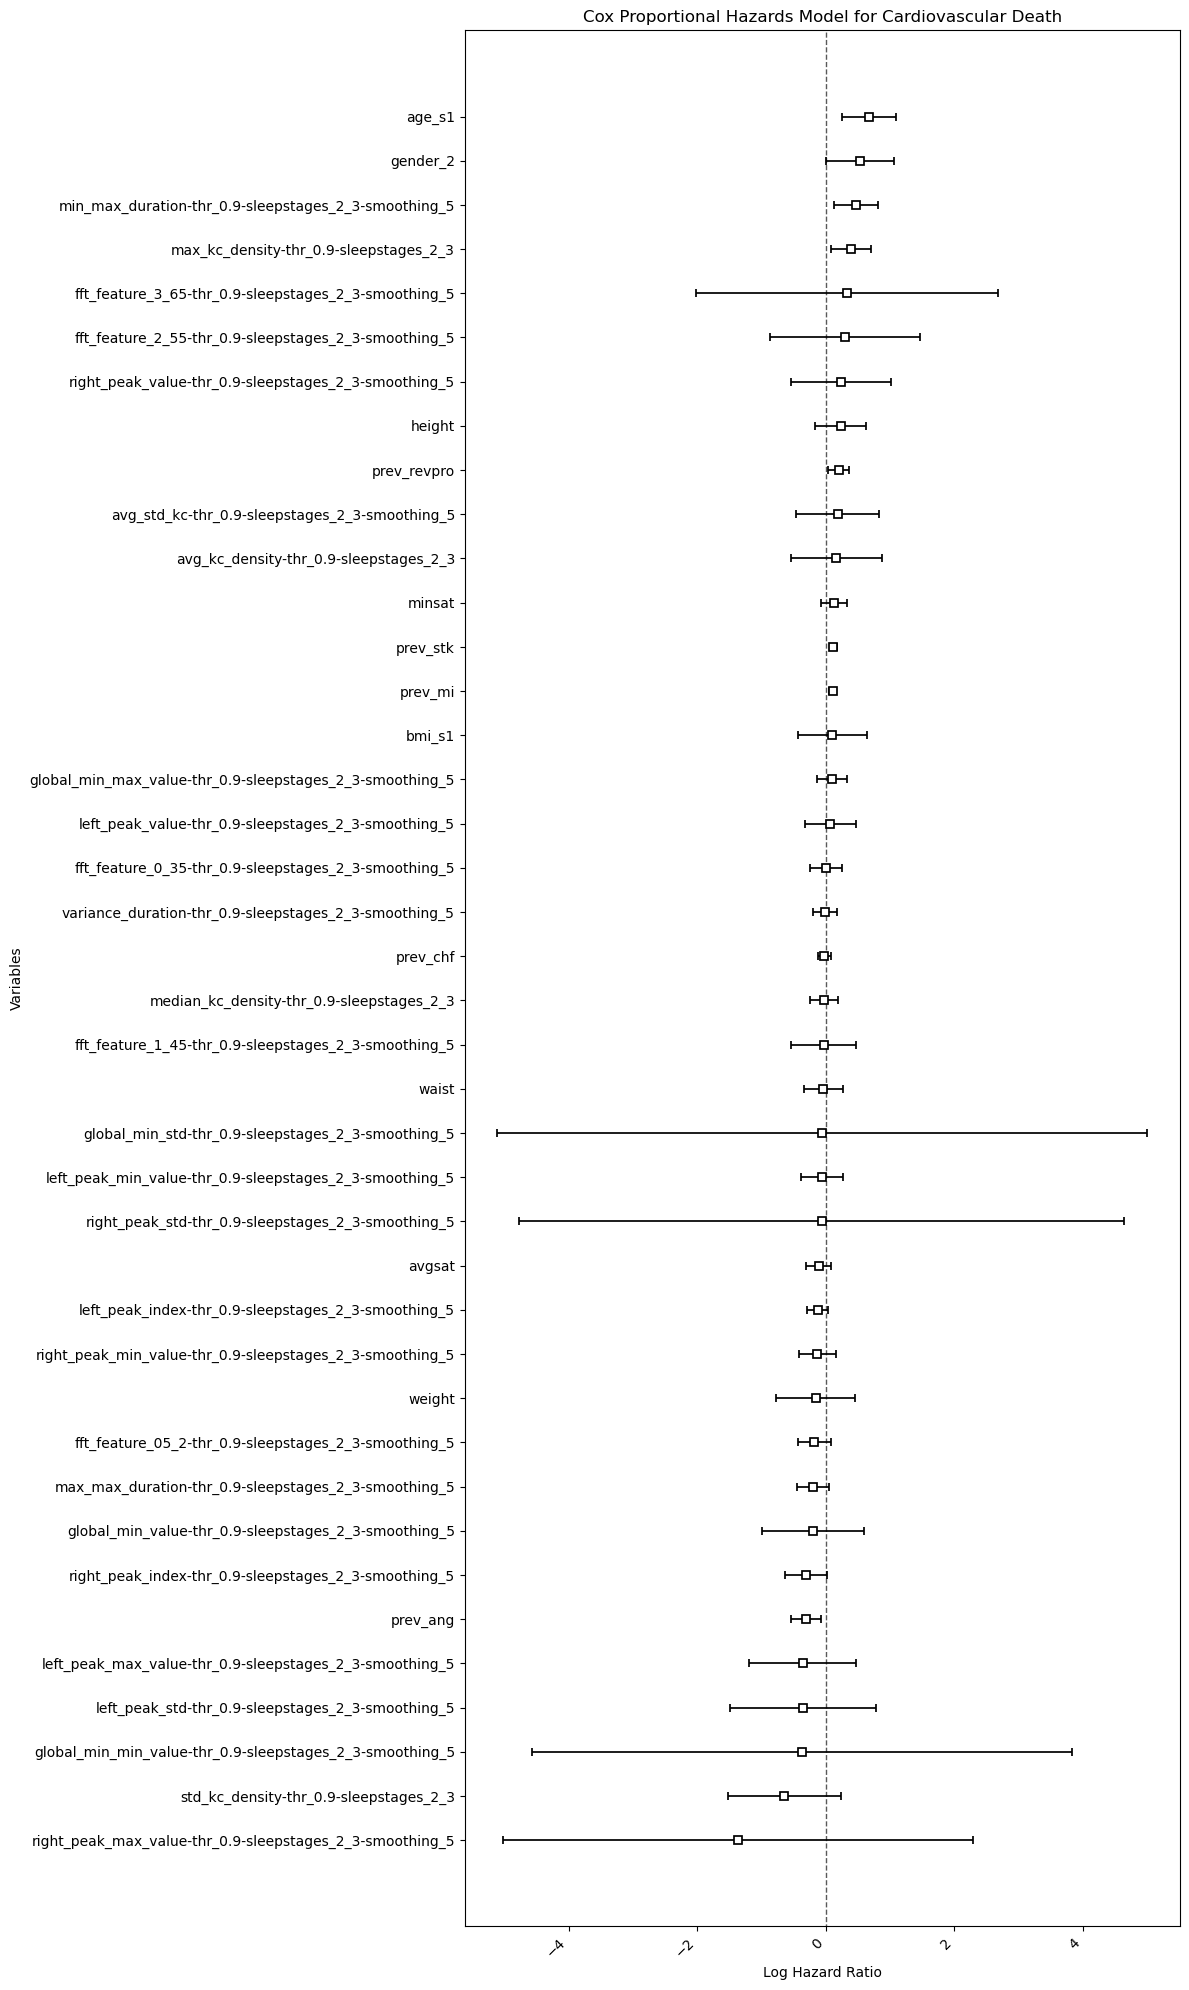

In [107]:
# Plot the survival function
plt.figure(figsize=(12, 20))  # Increase the figure size
cph.plot()
plt.title('Cox Proportional Hazards Model for Cardiovascular Death')
plt.xlabel('Log Hazard Ratio')
plt.ylabel('Variables')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Function to fit the Cox model, remove features, and save outputs
def refine_cox_model(data, duration_col, event_col, output_dir='output', threshold=0.05):
    cph = CoxPHFitter() 
    iteration = 1

    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    while True:
        # Fit the Cox Proportional Hazards Model
        cph.fit(data, duration_col=duration_col, event_col=event_col)
        summary = cph.summary
        
        # Format iteration number with leading zeros
        iteration_str = f"{iteration:03}"
        
        # Save the summary values
        summary_file = f"{output_dir}/cox_summary_iteration_{iteration_str}.csv"
        summary.to_csv(summary_file)
        
        # Plot the survival function
        plt.figure(figsize=(12, 20))  # Increase the figure size
        cph.plot()
        plt.title('Cox Proportional Hazards Model for Cardiovascular Death')
        plt.xlabel('Log Hazard Ratio')
        plt.ylabel('Variables')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
        plt.tight_layout()  # Adjust layout to make room for rotated labels
        plot_file = f"{output_dir}/cox_plot_iteration_{iteration_str}.png"
        plt.savefig(plot_file)
        plt.close()
        
        # Identify the feature with the highest p-value
        highest_p_value_feature = summary.loc[summary['p'] == summary['p'].max()].index[0]
        highest_p_value = summary['p'].max()
        
        # Stop if the highest p-value is below the threshold
        if highest_p_value < threshold:
            print(f"Stopping refinement at iteration {iteration_str}. All p-values are below the threshold of {threshold}.")
            break
        
        # Remove the feature with the highest p-value
        print(f"Iteration {iteration_str}: Removing feature '{highest_p_value_feature}' with p-value {highest_p_value}.")
        data = data.drop(columns=[highest_p_value_feature])
        
        iteration += 1

# Example usage:
# cox_data should be your dataframe, event_duration_col and event_event_col should be the column names for duration and event.
output_dir = os.path.join(kox_model_refinement_dir, "test-run")
print(output_dir)
cox_data_copy = cox_data.copy(deep=True)
refine_cox_model(cox_data_copy, event_duration_col, event_event_col, output_dir=output_dir)


/home/ec2-user/SageMaker/datasets/nsrr/shhs/kox-model-refinement/test-run
Iteration 001: Removing feature 'waist' with p-value 0.9776381787719038.
Iteration 002: Removing feature 'left_peak_std-thr_0.5-sleepstages_2_3-smoothing_5' with p-value 0.9615578737744715.
Iteration 003: Removing feature 'bmi_s1' with p-value 0.9213485144099111.
Iteration 004: Removing feature 'right_peak_std-thr_0.5-sleepstages_2_3-smoothing_5' with p-value 0.8372103095656197.
Iteration 005: Removing feature 'right_peak_min_value-thr_0.5-sleepstages_2_3-smoothing_5' with p-value 0.8029453626725374.
Iteration 006: Removing feature 'left_peak_min_value-thr_0.5-sleepstages_2_3-smoothing_5' with p-value 0.761019084689504.
Iteration 007: Removing feature 'global_min_std-thr_0.5-sleepstages_2_3-smoothing_5' with p-value 0.7706249451873365.
Iteration 008: Removing feature 'weight' with p-value 0.7618062779135609.
Iteration 009: Removing feature 'fft_feature_2_55-thr_0.5-sleepstages_2_3-smoothing_5' with p-value 0.7216

In [74]:
folder_to_zip

'/home/ec2-user/SageMaker/datasets/nsrr/shhs/kox-model-refinement/test-run'

In [535]:
!pip install pycox --quiet

In [544]:
import torchtuples as tt
from pycox.models import CoxPH
from pycox.datasets import metabric
from sklearn.preprocessing import StandardScaler
from pycox.evaluation import EvalSurv


# Preparing the data
df_train = cox_data.copy()
df_train['duration'] = cox_data[event_duration_col]
df_train['event'] = cox_data[event_event_col]

# Standardizing the data
#cols_standardize = ['primary_var1', 'primary_var2']
#standardize = [StandardScaler() for _ in cols_standardize]
x_train = df_train.drop(columns=['duration', 'event']).values.astype('float32')
y_train = (df_train['duration'].values.astype('float32'), df_train['event'].values.astype('float32'))

# Neural network definition
net = tt.practical.MLPVanilla(x_train.shape[1], [32, 32], output_bias=False, out_features=1)
model = CoxPH(net, tt.optim.Adam)

# Fitting the model
batch_size = 64
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose=False, val_data=(x_train, y_train))

# Compute baseline hazards
model.compute_baseline_hazards()

# Predict and evaluate
surv = model.predict_surv_df(x_train)
surv.index = surv.index.astype(float)  # Ensure the index is monotonic
surv.index.name = 'duration'

# Evaluate the model
ev = EvalSurv(surv, y_train[0], y_train[1], censor_surv='km')
c_index = ev.concordance_td('antolini')
print(f'Neural Network C-index: {c_index:.4f}')

AttributeError: 'Series' object has no attribute 'is_monotonic'

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator
kmf.fit(cox_data[event_duration_col], event_observed=cox_data[event_event_col])

# Plot the Kaplan-Meier curve
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

In [ ]:
from causaleval import evalue

# Example hazard ratios and confidence intervals
hazard_ratio = 1.5
lower_ci = 1.2
upper_ci = 1.8

evalue_val = evalue.hazard_ratio(hazard_ratio, lower_ci, upper_ci)
print(f"E-value: {evalue_val}")